<a href="https://colab.research.google.com/github/Safz14/CapstoneProjectCPS698/blob/main/Scale_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Assumes scale images are on your Drive under "Scales"

!ls /content/drive/MyDrive/Scales

 147863_1_L.tif    166183_5_L.tif   166694_2_L.tif    167781_6_L.tif    170384_8_L.tif
 148637_1_L.tif    166183_6_L.tif   166703_8_L.tif    167796_1_L.tif    170506_6_L.tif
 148637_4_L.tif    166183_7_L.tif   166710_7_L.tif    167797_7_L.tif    170580_2_L.tif
 148637_5_L.tif    166183_8_L.tif   166716_2_L.tif    167810_8_L.tif    171874_1_L.tif
 148637_8_L.tif    166184_3_L.tif   166716_6_L.tif    167811_6_L.tif    171874_2_L.tif
 148660_4_L.tif    166184_8_L.tif   166719_1_L.tif    167843_2_L.tif    171874_3_L.tif
 148690_6_L.tif    166246_7_L.tif   166731_2_L.tif    167843_5_L.tif    171874_5_L.tif
 148690_7_L.tif    166287_2_L.tif   166746_B7_L.tif   167843_6_L.tif    172811_3_L.tif
 148815_8_L.tif    166332_6_L.tif   166751_4_L.tif    167844_1_L.tif    172827_5_L.tif
 158324_1_L.tif    166334_1_L.tif   166754_2_L.tif    167858_1_L.tif    172829_8_L.tif
 158334_1_L.tif    166334_2_L.tif   166775_8_L.tif    167861_5_L.tif    172831_4_L.tif
 160110_1_L.tif    166334_5_L.tif   166776_

In [ ]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def scale_edge_detector(x,index, window_size, frequency_factor, orientation):
  if not (orientation == 'LR' or orientation == 'RL'):
    raise Exception("Edge detection orientation must be 'LR' or 'RL'.")

  if window_size % 2 != 1:
    raise Exception("Window size must be an odd number.")

  l_sum = np.sum(x[index - int(window_size / 2): index])
  r_sum = np.sum(x[index + 1: index + int(window_size / 2)])

  if orientation == 'LR':
    if r_sum > l_sum * frequency_factor:
      return True
    else:
      return False
  else:
    if r_sum * frequency_factor > l_sum:
      return True
    else:
      return False

def mask1d(gray_img, kernel_size, threshold=20):
  if kernel_size % 2 != 1:
    raise Exception("Kernel size must be an odd number.")


  mask = np.zeros(gray_img.shape, dtype=np.uint8)
  filter = np.ones(kernel_size) / kernel_size

  for y in range(gray_img.shape[0]):
    delta = np.convolve(gray_img[y,:], filter, mode='same') - gray_img[y,:]
    mask[y, (np.abs(delta) > threshold)] = 255.

  return mask

def mask(gray_img, kernel_size, threshold=20):
  if kernel_size % 2 != 1:
    raise Exception("Kernel size must be an odd number.")

  xd = mask1d(gray_img, 9, 20)
  yd = mask1d(np.transpose(gray_img), 9, 20).transpose()
  mask = xd /2 + yd / 2

  return mask

def denoise(gray_img, kernel_size, percent_activated_threshold=0.4):
  if kernel_size % 2 != 1:
    raise Exception("Kernel size must be an odd number.")

  activation_cutoff = percent_activated_threshold * kernel_size * kernel_size * 255
  denoised_img = gray_img.copy()

  for j in range(int(kernel_size / 2), gray_img.shape[0] - int(kernel_size / 2)):
    for k in range(int(kernel_size / 2), gray_img.shape[1] - int(kernel_size / 2)):
      if gray_img[j, k] > 120:
        if np.sum(gray_img[j:j+kernel_size,k:k+kernel_size]) < activation_cutoff:
          denoised_img[j, k] = 0

  return denoised_img

def detect_scale_contour(gray_img, padding=25):
  contour = []

  for j in range(padding, gray_img.shape[0] - padding):
    k = padding
    k_min = padding

    while k < gray_img.shape[1] - padding:
      if gray_img[j, k] > 0 and scale_edge_detector(gray_img[j,:], k, 25, 5, 'LR'):
        contour.append((j, k))
        k_min = k
        k = gray_img.shape[1] - padding
      k = k + 1

    while k > k_min:
      if gray_img[j, k] > 0 and scale_edge_detector(gray_img[j,:], k, 25, 5, 'RL'):
        contour.append((j, k))
        k = 0
      k = k - 1

  return contour

def dilate_contour(contour, thickness):

  dialated_contour = set()
  for (j, k) in contour:
    for l in range(j - thickness, j + thickness):
      for m in range(k - thickness, k + thickness):
        dialated_contour.add((l, m))

  return list(dialated_contour)

def draw_box(gray_img, top_left_point, bottom_right_point, color=255):
  j1, k1 = top_left_point
  j2, k2 = bottom_right_point

  gray_img[j1,k1:k2+1] = color
  gray_img[j2,k1:k2+1] = color

def draw_contour(size, contour, color=255):

  img = np.zeros(size, dtype=np.uint8)
  for (j, k) in contour:
    img[j, k] = color

  return img

def show_image_and_contour(file):
  img = imread(file)

  print(file)
  gray = rgb2gray(img)
  plt.imshow(gray, cmap=plt.get_cmap('gray'))
  plt.show()

  masked_image = mask(gray, 9, 20)
  denoised_mask = denoise(masked_image, 101, .025)

  contour = detect_scale_contour(denoised_mask, 100)
  dilated_contour = dilate_contour(contour, 5)
  drawn_contour = draw_contour(denoised_mask.shape, dilated_contour)

  plt.imshow(np.abs(drawn_contour - 255), cmap=plt.get_cmap('gray'))
  plt.show()




/content/drive/MyDrive/Scales/160653_8_L.tif


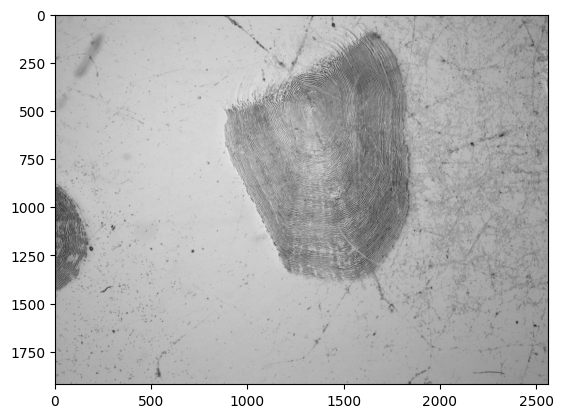

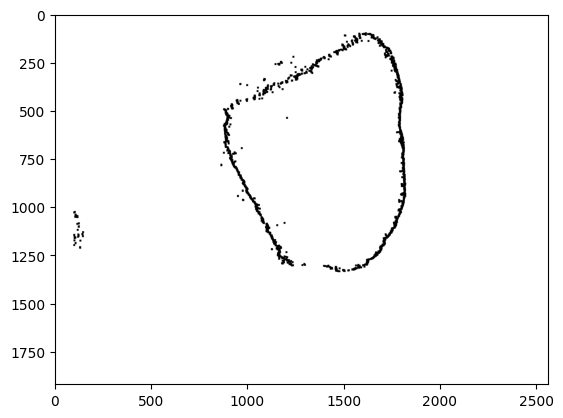

/content/drive/MyDrive/Scales/160653_1_L.tif


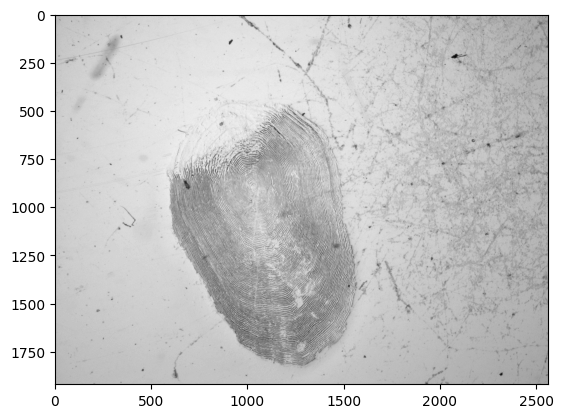

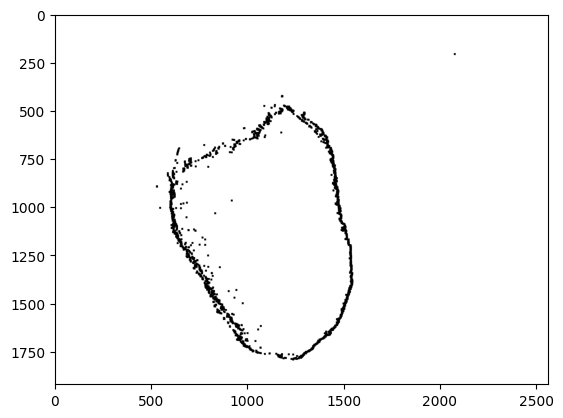

/content/drive/MyDrive/Scales/160110_1_L.tif


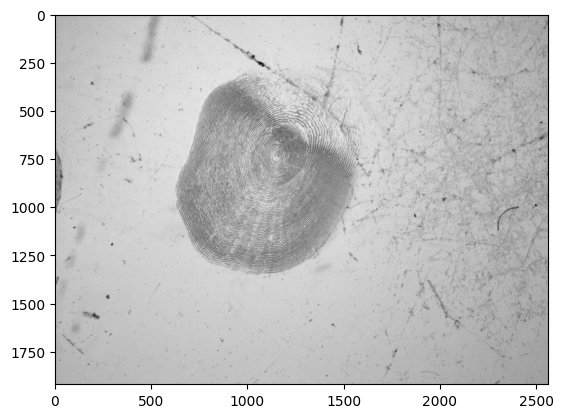

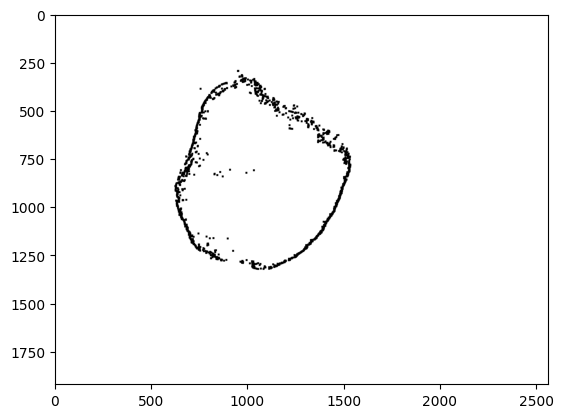

/content/drive/MyDrive/Scales/160653_3_L.tif


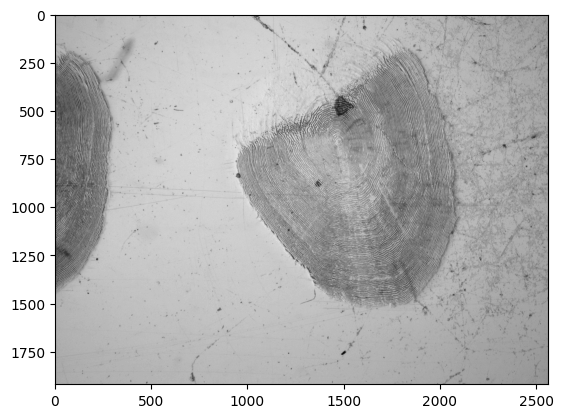

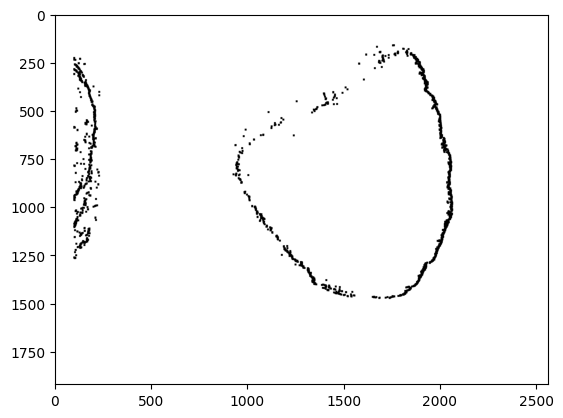

/content/drive/MyDrive/Scales/160653_2_L.tif


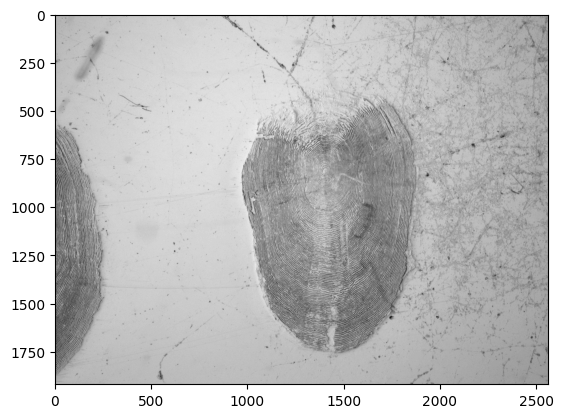

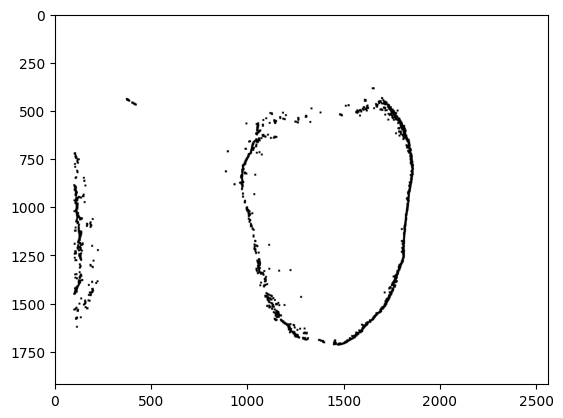

In [ ]:
import glob

for image_file in glob.glob("/content/drive/MyDrive/Scales/*tif"):
  show_image_and_contour(image_file)

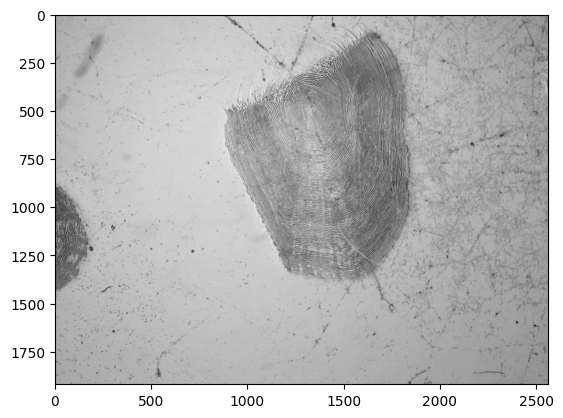

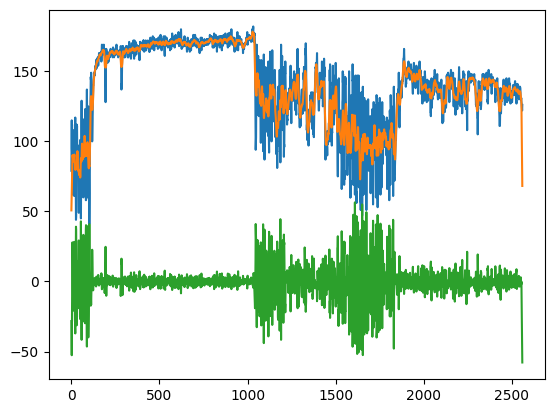

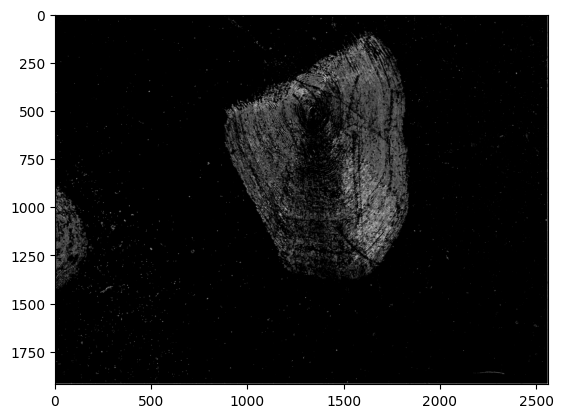

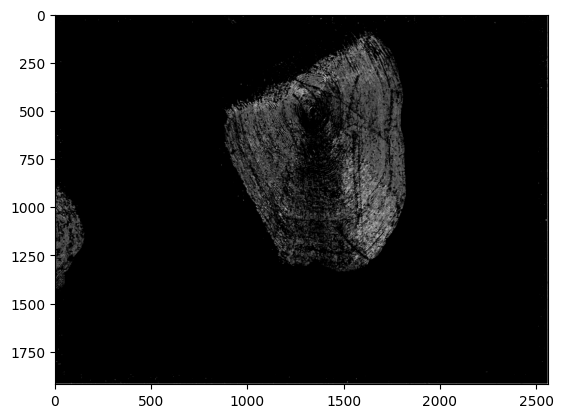

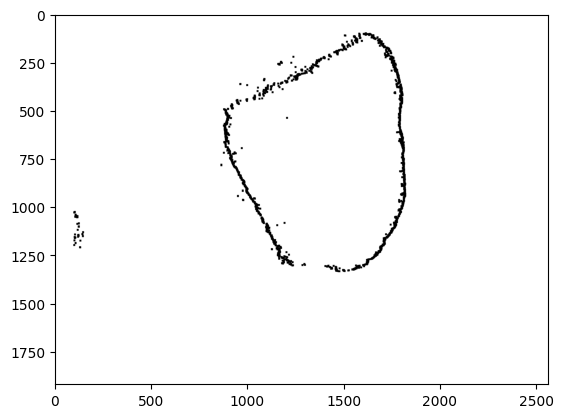

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Read the original image
img = cv2.imread('/content/drive/MyDrive/Scales/160653_8_L.tif')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray, cmap=plt.get_cmap('gray'))
plt.show()

# Demostrates finding an average over 11 pixels and then plotting
#  difference from average.  Note how the scale pops.
filter = np.ones(11) / 11
avg = np.convolve(img_gray[1000,:], filter, mode='same')
delta = avg - img_gray[1000,:]

plt.plot(img_gray[1000,:])
plt.plot(avg)
plt.plot(delta)
plt.show()

# Shows mask that makes use of the convolution
msk = mask(img_gray, 11, 20)
plt.imshow(msk, cmap=plt.get_cmap('gray'))
plt.show()

# Mask can be denoised
denoised_mask = denoise(msk, 101, 0.025)
plt.imshow(denoised_mask, cmap=plt.get_cmap('gray'))
plt.show()

# Denoised mask can be used to find contours
contour = detect_scale_contour(denoised_mask, 100)
dilated_contour = dilate_contour(contour, 5)
drawn_contour = draw_contour(denoised_mask.shape, dilated_contour)

plt.imshow(np.abs(drawn_contour - 255), cmap=plt.get_cmap('gray'))
plt.show()
